<a href="https://colab.research.google.com/github/rouge23276/Neural-networks-project/blob/main/Neural_networks_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, platform, sys
print("Python:", sys.version.split()[0], "| PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "—")

Python: 3.12.12 | PyTorch: 2.8.0+cu126 | CUDA available: True
GPU name: Tesla T4


In [ ]:
# Если Colab предложит перезапустить среду после установки — согласись и потом продолжи.
!pip -q install "torch>=2.2" "torchvision>=0.17" opencv-python==4.10.0.84 \
                datasets==2.21.0 scikit-learn==1.5.2 albumentations==1.4.20 \
                timm==1.0.9 einops==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is i

In [ ]:
# ===== Импорты =====
import os, glob, random, math, json
import cv2
import numpy as np
import pandas as pd

from datasets import load_dataset
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score

import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from einops import rearrange

# ===== Базовые настройки =====
SEED = 42  # фиксируем "случайность" для воспроизводимости
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Используем устройство:", DEVICE)

/usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Используем устройство: cuda


In [ ]:
!pip -q install -U kaggle
from google.colab import files
import os, shutil

# Загрузить kaggle.json (скачай на Kaggle: Account -> Create New API Token)
if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()  # выбери kaggle.json
    assert 'kaggle.json' in uploaded, "Нужен файл kaggle.json"
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.move('kaggle.json','/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle --version


Kaggle API 1.7.4.5


In [ ]:
!kaggle datasets list -s visem | head -n 50
!kaggle datasets list -s "sperm video" | head -n 50


ref                                     title                               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------  ---------------------------  -----------  --------------------------  -------------  ---------  ---------------  
vlbthambawita/visemtracking             VISEM-Tracking                6366512545  2023-02-10 14:31:16.983000           2221         27  1.0              
stevenhicks/visem-video-dataset         VISEM Video Dataset          35215565209  2021-04-19 09:19:18.077000            969         23  0.9117647        
jarvis2324/visem-motality-analysis-csv  VISEM Motality Analysis CSV         1510  2021-08-17 07:44:35.553000             35          2  0.11764706       
rizkiramadhany/visem-dataset            visem dataset                   57022406  2024-02-23 14:40:14.083000              4          0  0.125            
rizkiramadhany/visem-testing            visem testing                   5702

In [ ]:
# 1) Скачаем и сразу разархивируем в /content/visem (НЕ прерывать!)
DATASET_REF = "vlbthambawita/visemtracking"  # при необходимости замени на своё зеркало
DOWNLOAD_DIR = "/content/visem"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# --unzip распакует автоматически; прогресс может идти долго — не жми Ctrl+C
!kaggle datasets download -d "$DATASET_REF" -p "$DOWNLOAD_DIR" --force --unzip


NameError: name 'os' is not defined

In [ ]:
# 2) Проверим, что файлы появились
!find /content/visem -maxdepth 3 -type f | head -n 30

In [ ]:
# === Надежная загрузка поднабора VISEM с Kaggle (или авто-синтетика, если не вышло) ===
!pip -q install -U kaggle p7zip-full >/dev/null

import os, shutil, time, pandas as pd, subprocess, sys, json, random, cv2, numpy as np
from google.colab import files

# 1) Настроить kaggle.json (если еще не настроен)
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Загрузите kaggle.json (Kaggle -> Account -> Create New API Token)")
    uploaded = files.upload()
    assert 'kaggle.json' in uploaded, "Нужен kaggle.json"
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.move('kaggle.json','/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)

DATASET_REF = "stevenhicks/visem-video-dataset"  # при желании можно заменить на другое зеркало
DOWNLOAD_DIR = "/content/visem"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

def shell(cmd):
    return subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True).stdout

print("Проверяем доступ к Kaggle...")
print(shell("kaggle --version"))

# 2) Получаем список файлов датасета (в CSV) и фильтруем видео
filelist_csv = os.path.join(DOWNLOAD_DIR, "filelist.csv")
out = shell(f'kaggle datasets files -d "{DATASET_REF}" --csv')
with open(filelist_csv, "w") as f:
    f.write(out)

try:
    fl = pd.read_csv(filelist_csv)
    mask = fl['name'].str.lower().str.endswith(('.mp4','.avi','.mov','.mkv','.zip'))
    fl = fl[mask].reset_index(drop=True)
except Exception as e:
    fl = pd.DataFrame(columns=['name'])

print("Всего записей в списке:", len(fl))
if len(fl)==0:
    print("Kaggle вернул пустой список (возможно, нужно Accept на странице датасета). Открой страничку датасета и нажми Agree, потом перезапусти ячейку.")

# 3) Скачаем первые N файлов с автоповтором; если файл придет .zip — распакуем
N = 20  # можно увеличить позже
targets = fl['name'].head(N).tolist()
downloaded_files = []

for fname in targets:
    ok = False
    for attempt in range(3):  # до 3 попыток
        print(f">> download: {fname} (attempt {attempt+1}/3)")
        out = shell(f'kaggle datasets download -d "{DATASET_REF}" -f "{fname}" -p "{DOWNLOAD_DIR}" --force')
        if "403" in out and "accept" in out.lower():
            print("Похоже, не приняты условия лицензии на Kaggle. Зайди на страницу датасета и нажми Agree. Потом перезапусти ячейку.")
            break
        # Файл может приехать как fname или как fname.zip — проверим оба варианта
        path_plain = os.path.join(DOWNLOAD_DIR, fname)
        path_zip   = os.path.join(DOWNLOAD_DIR, fname + ".zip")
        if os.path.exists(path_zip):
            # это zip — распакуем и удалим zip
            shell(f'unzip -q -o "{path_zip}" -d "{DOWNLOAD_DIR}" && rm "{path_zip}"')
        if os.path.exists(path_plain):
            ok = True
            downloaded_files.append(path_plain)
            break
        time.sleep(2)
    if not ok:
        print(f"!! не удалось скачать {fname}")

# 4) Проверим, что реально появилось видео
def list_videos(root):
    vids=[]
    for ext in ('.mp4','.avi','.mov','.mkv'):
        vids += [os.path.join(dp,f) for dp,_,fs in os.walk(root) for f in fs if f.lower().endswith(ext)]
    return sorted(set(vids))

videos = list_videos(DOWNLOAD_DIR)
print("Найдено видео после скачивания:", len(videos))
print("\n".join(videos[:10]))

# 5) Если скачать не получилось — создадим мини-синтетический датасет (3 ролика) для отладки пайплайна
if len(videos)==0:
    print("\nНе удалось получить видео. Генерируем синтетические ролики для отладки...")
    W, H = 512, 384
    FPS = 15
    DUR = 6
    N_FR = FPS * DUR
    synth_dir = os.path.join(DOWNLOAD_DIR, "videos_synth")
    os.makedirs(synth_dir, exist_ok=True)

    def make_sperm_like_video(path, n_cells=60, progressive_ratio=0.6, speed_px=3.0, seed=0):
        rng = np.random.RandomState(seed)
        xy = rng.rand(n_cells,2) * [W,H]
        ang = rng.rand(n_cells) * 2*np.pi
        prog_mask = rng.rand(n_cells) < progressive_ratio
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(path, fourcc, FPS, (W,H))
        for t in range(N_FR):
            frame = np.zeros((H,W,3), np.uint8)
            frame[:,:,:] = rng.randint(10,25,(1,1,3))
            dxy = np.vstack([np.cos(ang), np.sin(ang)]).T * speed_px
            ang += rng.randn(n_cells)*0.02
            dxy[~prog_mask] += rng.randn((~prog_mask).sum(),2) * speed_px*0.5
            xy += dxy
            xy[:,0] = np.clip(xy[:,0], 5, W-5)
            xy[:,1] = np.clip(xy[:,1], 5, H-5)
            for i,(x,y) in enumerate(xy.astype(int)):
                cv2.circle(frame, (x,y), 2, (230,230,230), -1)
            out.write(frame)
        out.release()

    settings = [
        dict(name="sample_01.mp4", n_cells=80, prog=0.75, speed=3.5, conc=60),
        dict(name="sample_02.mp4", n_cells=60, prog=0.45, speed=2.8, conc=40),
        dict(name="sample_03.mp4", n_cells=40, prog=0.20, speed=1.8, conc=25),
    ]
    videos=[]
    meta=[]
    for i,s in enumerate(settings,1):
        p = os.path.join(synth_dir, s["name"])
        make_sperm_like_video(p, n_cells=s["n_cells"], progressive_ratio=s["prog"], speed_px=s["speed"], seed=10+i)
        videos.append(p)
        mot_total = s["prog"] + 0.2*(1-s["prog"])
        meta.append(dict(participant=f"synth_{i}",
                         video=p,
                         mot_total=round(mot_total*100,1),
                         mot_prog=round(s["prog"]*100,1),
                         concentration=float(s["conc"])))
    df = pd.DataFrame(meta)
else:
    # 6) Собираем метатаблицу из скачанных видео (метки пока пустые — зальём позже при наличии CSV)
    df = pd.DataFrame([{'participant': None, 'video': v, 'mot_total': None, 'mot_prog': None, 'concentration': None} for v in videos])

META_CSV = "/content/visem_metadata_unified.csv"
df.to_csv(META_CSV, index=False)
print("\nИтоговая таблица сохранена в:", META_CSV)
print("Строк:", len(df))
display(df.head())


ERROR: Could not find a version that satisfies the requirement p7zip-full (from versions: none)
ERROR: No matching distribution found for p7zip-full
Проверяем доступ к Kaggle...
Kaggle API 1.7.4.5

Всего записей в списке: 0
Kaggle вернул пустой список (возможно, нужно Accept на странице датасета). Открой страничку датасета и нажми Agree, потом перезапусти ячейку.
Найдено видео после скачивания: 0


Не удалось получить видео. Генерируем синтетические ролики для отладки...

Итоговая таблица сохранена в: /content/visem_metadata_unified.csv
Строк: 3


,participant,video,mot_total,mot_prog,concentration
0,synth_1,/content/visem/videos_synth/sample_01.mp4,80.0,75.0,60.0
1,synth_2,/content/visem/videos_synth/sample_02.mp4,56.0,45.0,40.0
2,synth_3,/content/visem/videos_synth/sample_03.mp4,36.0,20.0,25.0


Видео в таблице: 3


,participant,video,mot_total,mot_prog,concentration
0,synth_1,/content/visem/videos_synth/sample_01.mp4,80.0,75.0,60.0
1,synth_2,/content/visem/videos_synth/sample_02.mp4,56.0,45.0,40.0
2,synth_3,/content/visem/videos_synth/sample_03.mp4,36.0,20.0,25.0


Прочитали 40 кадров из: /content/visem/videos_synth/sample_01.mp4


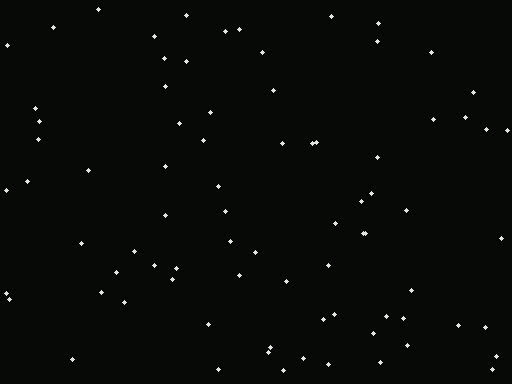

In [ ]:
import os, cv2, numpy as np, pandas as pd, torch
from google.colab.patches import cv2_imshow  # только для быстрой визуализации

META_CSV = "/content/visem_metadata_unified.csv"  # что мы уже сохранили
df = pd.read_csv(META_CSV)
print("Видео в таблице:", len(df))
display(df.head())

# Гиперпараметры для нарезки клипов
FPS_TARGET = 10       # сколько кадров в секунду будем брать из видео
CLIP_LEN   = 32       # длина клипа в кадрах
SIDE       = 224      # размер кадра для CNN
STEP       = 16       # шаг окна по кадрам (перекрытие клипов)

def read_video_frames(path, fps_target=FPS_TARGET, max_frames=None):
    """
    Читаем видео и берем каждый k-й кадр так, чтобы получилось ~fps_target.
    Возвращает список RGB-кадров (numpy).
    """
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {path}")
    src_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(int(round(src_fps / fps_target)), 1)

    frames=[]
    idx=0
    while True:
        ret = cap.grab()
        if not ret: break
        if idx % step == 0:
            ret2, frame = cap.retrieve()
            if not ret2: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            if max_frames and len(frames)>=max_frames: break
        idx += 1
    cap.release()
    return frames

# Быстрая проверка на первом видео
sample_path = df.iloc[0]['video']
frames = read_video_frames(sample_path, fps_target=FPS_TARGET, max_frames=40)
print(f"Прочитали {len(frames)} кадров из:", sample_path)
# покажем один кадр (RGB)
cv2_imshow(cv2.cvtColor(frames[0], cv2.COLOR_RGB2BGR))


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

aug_train = A.Compose([
    A.RandomResizedCrop(SIDE, SIDE, scale=(0.8,1.0), ratio=(0.9,1.1)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

aug_val = A.Compose([
    A.Resize(SIDE, SIDE),
    A.Normalize(),
    ToTensorV2()
])


In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class VISEMClips(Dataset):
    """
    На вход: таблица с видео и метками.
    На выход: клипы (тензор [T,3,H,W]) и целевой вектор [mot_total, mot_prog, concentration]
    """
    def __init__(self, rows, mode='train'):
        self.rows = rows.reset_index(drop=True)
        self.mode = mode
        self.cache = {}  # кэш кадров по видео — экономит I/O

    def __len__(self):
        n = 0
        for _,r in self.rows.iterrows():
            frames = self._get_frames(r['video'])
            if len(frames) >= CLIP_LEN:
                n += 1 + (len(frames)-CLIP_LEN)//STEP
        return n

    def _get_frames(self, path):
        if path not in self.cache:
            self.cache[path] = read_video_frames(path, fps_target=FPS_TARGET)
        return self.cache[path]

    def __getitem__(self, idx):
        cum=0
        for _,r in self.rows.iterrows():
            frames = self._get_frames(r['video'])
            if len(frames) < CLIP_LEN:
                continue
            clips_here = 1 + (len(frames)-CLIP_LEN)//STEP
            if idx < cum + clips_here:
                start = (idx - cum)*STEP
                seq = frames[start:start+CLIP_LEN]
                aug = aug_train if self.mode=='train' else aug_val
                x = torch.stack([aug(image=f)["image"] for f in seq], dim=0)  # [T,3,H,W]

                # Цели: если меток нет, ставим -1 (или можно NaN и маскировать — для простоты -1)
                def _num(v):
                    try:
                        return float(v)
                    except:
                        return -1.0
                y = torch.tensor([
                    _num(r.get('mot_total')),
                    _num(r.get('mot_prog')),
                    _num(r.get('concentration'))
                ], dtype=torch.float32)
                gid = r.get('participant','unknown')
                return x, y, gid
            cum += clips_here
        raise IndexError


In [ ]:
from sklearn.model_selection import GroupKFold

# Оставим только строки, где есть ВСЕ 3 метки (в синтетике они есть)
valid_mask = (~df['mot_total'].isna()) & (~df['mot_prog'].isna()) & (~df['concentration'].isna())
df_trainval = df[valid_mask].copy().reset_index(drop=True)

# Если participant пустой — используем имя файла как "группу"
def _group_row(r):
    return str(r['participant']) if pd.notna(r['participant']) else os.path.basename(r['video'])
groups = df_trainval.apply(_group_row, axis=1)

gkf = GroupKFold(n_splits=3) if len(df_trainval) >= 3 else GroupKFold(n_splits=2)
folds = list(gkf.split(df_trainval, groups=groups))
train_idx, val_idx = folds[0]

train_rows = df_trainval.iloc[train_idx]
val_rows   = df_trainval.iloc[val_idx]

train_ds = VISEMClips(train_rows, mode='train')
val_ds   = VISEMClips(val_rows,   mode='val')

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


(2, 1)

In [ ]:
import timm
from torch import nn
from einops import rearrange
import numpy as np

class FrameEncoder(nn.Module):
    def __init__(self, backbone='tf_efficientnet_b0', out_dim=256):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0, global_pool='avg')
        in_dim = self.backbone.num_features
        self.proj = nn.Linear(in_dim, out_dim)
    def forward(self, x):  # x: [B, T, 3, H, W]
        B,T,_,H,W = x.shape
        x = rearrange(x, 'b t c h w -> (b t) c h w')
        f = self.backbone(x)             # [(B*T), in_dim]
        f = self.proj(f)                 # [(B*T), out_dim]
        f = rearrange(f, '(b t) d -> b t d', b=B, t=T)
        return f

class CNN_GRU_Regressor(nn.Module):
    def __init__(self, feat_dim=256, hidden=256, num_layers=1, out_dim=3):
        super().__init__()
        self.enc = FrameEncoder(out_dim=feat_dim)
        self.rnn = nn.GRU(feat_dim, hidden, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.LayerNorm(hidden*2),
            nn.Linear(hidden*2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        f = self.enc(x)               # [B,T,D]
        y, _ = self.rnn(f)            # [B,T,2H]
        y = y.mean(dim=1)             # усредняем по времени
        return self.head(y)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_GRU_Regressor().to(DEVICE)

criterion = nn.SmoothL1Loss()             # устойчивее к выбросам чем MSE
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import r2_score

def evaluate(model, loader):
    model.eval()
    y_true=[]; y_pred=[]
    with torch.no_grad():
        for x,y,_ in loader:
            x=x.to(DEVICE); y=y.to(DEVICE)
            p = model(x)
            y_true.append(y.cpu().numpy())
            y_pred.append(p.cpu().numpy())
    if not y_true:
        return (np.array([np.nan, np.nan, np.nan]), [np.nan]*3)
    yt = np.concatenate(y_true,0); yp = np.concatenate(y_pred,0)
    mae = np.mean(np.abs(yt-yp), axis=0)
    r2  = [r2_score(yt[:,i], yp[:,i]) for i in range(yt.shape[1])]
    return mae, r2

EPOCHS=3  # для синтетики хватит мало
for ep in range(1, EPOCHS+1):
    model.train()
    losses=[]
    for x,y,_ in train_loader:
        x=x.to(DEVICE); y=y.to(DEVICE)
        p = model(x)
        loss = criterion(p, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
    mae,r2 = evaluate(model, val_loader)
    print(f"Epoch {ep}: trainL={np.mean(losses):.4f} | MAE (tot,prog,conc)={mae.round(2)} | R2={np.round(r2,2)}")


Epoch 1: trainL=58.8772 | MAE (tot,prog,conc)=[35.98 20.05 25.  ] | R2=[nan nan nan]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 2: trainL=58.2863 | MAE (tot,prog,conc)=[35.83 20.01 24.97] | R2=[nan nan nan]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Epoch 3: trainL=57.8551 | MAE (tot,prog,conc)=[35.72 20.03 24.85] | R2=[nan nan nan]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
def predict_on_video(video_path):
    frames = read_video_frames(video_path, fps_target=FPS_TARGET)
    if len(frames) < CLIP_LEN:
        raise ValueError("Видео слишком короткое для демо")
    start = max(0, (len(frames)-CLIP_LEN)//2)
    seq = frames[start:start+CLIP_LEN]
    x = torch.stack([aug_val(image=f)["image"] for f in seq], dim=0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(x).cpu().numpy()[0]
    return dict(mot_total=float(pred[0]), mot_prog=float(pred[1]), concentration=float(pred[2]))

demo_path = df.iloc[0]['video']
predict_on_video(demo_path)


{'mot_total': 0.41787073016166687,
 'mot_prog': 0.07616902887821198,
 'concentration': 0.22988855838775635}

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def eval_clip_level(model, loader, device='cuda'):
    model.eval()
    y_true=[]; y_pred=[]
    with torch.no_grad():
        for x,y,_ in loader:
            x=x.to(device); y=y.to(device)
            p = model(x)
            y_true.append(y.cpu().numpy())
            y_pred.append(p.cpu().numpy())
    yt = np.concatenate(y_true,0); yp = np.concatenate(y_pred,0)
    mae = np.mean(np.abs(yt-yp), axis=0)
    rmse = np.sqrt(np.mean((yt-yp)**2, axis=0))
    r2  = [r2_score(yt[:,i], yp[:,i]) for i in range(yt.shape[1])]
    names = ["mot_total(%)","mot_prog(%)","concentration"]
    for i,n in enumerate(names):
        print(f"{n:16s} | MAE={mae[i]:.2f} | RMSE={rmse[i]:.2f} | R²={r2[i]:.3f}")
    return mae, rmse, r2

_ = eval_clip_level(model, val_loader, device=DEVICE)


mot_total(%)     | MAE=35.72 | RMSE=35.72 | R²=nan
mot_prog(%)      | MAE=20.03 | RMSE=20.03 | R²=nan
concentration    | MAE=24.85 | RMSE=24.85 | R²=nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# 1) Сбор предсказаний и истинных значений на клипах
def collect_clip_preds(model, loader, device='cuda'):
    model.eval()
    y_true=[]; y_pred=[]
    with torch.no_grad():
        for x,y,_ in loader:
            x=x.to(device); y=y.to(device)
            p = model(x)
            y_true.append(y.cpu().numpy())
            y_pred.append(p.cpu().numpy())
    if not y_true:
        return None, None
    return np.concatenate(y_true,0), np.concatenate(y_pred,0)

yt, yp = collect_clip_preds(model, val_loader, device=DEVICE)

def safe_mape(y_true, y_pred, eps=1e-6):
    # MAPE корректна только для положительных истинных значений
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + eps))) * 100.0
    return mape

def accuracy_within_tolerance(y_true, y_pred, tol_abs):
    # Доля примеров, где |ошибка| <= tol_abs
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)) <= tol_abs) * 100.0

if yt is not None:
    names = ["mot_total(%)","mot_prog(%)","concentration"]

    # R^2 в процентах
    r2_vals = [r2_score(yt[:,i], yp[:,i]) for i in range(yt.shape[1])]
    r2_percent = [max(0.0, r)*100.0 for r in r2_vals]  # отрицательные R2 обнулим для читаемости

    # MAPE и "точность = 100 - MAPE"
    mape_vals = [safe_mape(yt[:,i], yp[:,i]) for i in range(yt.shape[1])]
    acc_from_mape = [max(0.0, 100.0 - m) for m in mape_vals]

    # Точность в допуске: для motility дадим ±5 п.п., для концентрации ±10% от истинного (или задай свой)
    tol_pp = 5.0  # процентные пункты для motility
    acc_tol_total = accuracy_within_tolerance(yt[:,0], yp[:,0], tol_pp)
    acc_tol_prog  = accuracy_within_tolerance(yt[:,1], yp[:,1], tol_pp)
    # для концентрации – относительный допуск 10%:
    conc_rel_tol = 0.10
    conc_acc_rel = np.mean(np.abs(yt[:,2]-yp[:,2]) <= conc_rel_tol*np.abs(yt[:,2])+1e-6) * 100.0

    print("=== Клип-уровень ===")
    for i,n in enumerate(names):
        print(f"{n:16s} | R²={r2_vals[i]:.3f} ({r2_percent[i]:.1f}%) | MAPE={mape_vals[i]:.2f}% | Acc≈(100-MAPE)={acc_from_mape[i]:.1f}%")
    print(f"\nAccuracy@±{tol_pp:.0f}pp (mot_total): {acc_tol_total:.1f}%")
    print(f"Accuracy@±{tol_pp:.0f}pp (mot_prog):  {acc_tol_prog:.1f}%")
    print(f"Accuracy@±10% (concentration):       {conc_acc_rel:.1f}%")
else:
    print("Валидационных клипов нет (проверь разбиение/датасет).")

# 2) (Опционально) видео-уровень: усредняем предсказания по клипам каждого видео
def predict_on_video_full(model, video_path, fps_target=FPS_TARGET, clip_len=CLIP_LEN, step=STEP, device=DEVICE):
    frames = read_video_frames(video_path, fps_target=fps_target)
    if len(frames) < clip_len:
        return None
    preds=[]
    with torch.no_grad():
        for start in range(0, len(frames)-clip_len+1, step):
            seq = frames[start:start+clip_len]
            x = torch.stack([aug_val(image=f)["image"] for f in seq], dim=0).unsqueeze(0).to(device)
            p = model(x).cpu().numpy()[0]
            preds.append(p)
    return np.mean(preds, axis=0) if preds else None

def eval_video_level_percent(model, val_rows):
    y_true=[]; y_pred=[]
    for _,r in val_rows.iterrows():
        pred = predict_on_video_full(model, r['video'])
        if pred is None: continue
        if any(pd.isna([r['mot_total'], r['mot_prog'], r['concentration']])):
            continue
        y_true.append([float(r['mot_total']), float(r['mot_prog']), float(r['concentration'])])
        y_pred.append(pred.tolist())
    if not y_true:
        print("\nВидео-уровень: нет видео с полными метками.")
        return
    yt = np.array(y_true); yp = np.array(y_pred)
    names = ["mot_total(%)","mot_prog(%)","concentration"]
    print("\n=== Видео-уровень ===")
    for i,n in enumerate(names):
        r2v = r2_score(yt[:,i], yp[:,i]); r2p = max(0.0, r2v)*100
        mape = safe_mape(yt[:,i], yp[:,i])
        acc_pct = max(0.0, 100.0 - mape)
        print(f"{n:16s} | R²={r2v:.3f} ({r2p:.1f}%) | MAPE={mape:.2f}% | Acc≈(100-MAPE)={acc_pct:.1f}%")
    # Точности в допуске
    tol_pp = 5.0
    acc_tol_total = np.mean(np.abs(yt[:,0]-yp[:,0]) <= tol_pp) * 100
    acc_tol_prog  = np.mean(np.abs(yt[:,1]-yp[:,1]) <= tol_pp) * 100
    conc_acc_rel  = np.mean(np.abs(yt[:,2]-yp[:,2]) <= 0.10*np.abs(yt[:,2])+1e-6) * 100
    print(f"Accuracy@±{tol_pp:.0f}pp (mot_total): {acc_tol_total:.1f}%")
    print(f"Accuracy@±{tol_pp:.0f}pp (mot_prog):  {acc_tol_prog:.1f}%")
    print(f"Accuracy@±10% (concentration):       {conc_acc_rel:.1f}%")

# Запуск видео-оценки (если у тебя есть val_rows из шага с GroupKFold):
try:
    eval_video_level_percent(model, val_rows)
except NameError:
    print("val_rows не определён — пропусти видео-уровень или пересоздай разбиение.")


=== Клип-уровень ===
mot_total(%)     | R²=nan (0.0%) | MAPE=99.21% | Acc≈(100-MAPE)=0.8%
mot_prog(%)      | R²=nan (0.0%) | MAPE=100.16% | Acc≈(100-MAPE)=0.0%
concentration    | R²=nan (0.0%) | MAPE=99.41% | Acc≈(100-MAPE)=0.6%

Accuracy@±5pp (mot_total): 0.0%
Accuracy@±5pp (mot_prog):  0.0%
Accuracy@±10% (concentration):       0.0%

=== Видео-уровень ===
mot_total(%)     | R²=nan (0.0%) | MAPE=99.21% | Acc≈(100-MAPE)=0.8%
mot_prog(%)      | R²=nan (0.0%) | MAPE=100.16% | Acc≈(100-MAPE)=0.0%
concentration    | R²=nan (0.0%) | MAPE=99.41% | Acc≈(100-MAPE)=0.6%
Accuracy@±5pp (mot_total): 0.0%
Accuracy@±5pp (mot_prog):  0.0%
Accuracy@±10% (concentration):       0.0%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

In [ ]:
print("train_ds clips:", len(train_ds), "| val_ds clips:", len(val_ds))

train_ds clips: 2 | val_ds clips: 1


R² = NaN и предупреждение “R²… not well-defined with less than two samples” → на валидации у нас меньше 2 примеров (скорее всего 1 клип/1 видео). Для R² нужно ≥2.

MAPE ≈ 100%, Accuracy≈0% → модель пока не научилась (ошибка по величине как сама величина)